In [1]:
import os
import json
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk

In [2]:
class SkinDiseasePredictor:
    def __init__(self, model_path='trained_model.h5'):
        # Class names matching the training order
        self.class_names = [
            'Acitinic Keratosis',
            'Basal Cell Carcinoma',
            'Dermatofibroma',
            'Melanoma',
            'Nevus',
            'Pigmented Benign Keratosis',
            'Seborrheic Keratosis',
            'Squamous Cell Carcinoma',
            'Vascular Lesion'
        ]
        
        self.target_size = (224, 224)
        
        # Load model
        print("Loading model...")
        self.model = load_model(model_path)
        print(f"Model loaded successfully! Available classes: {self.class_names}")
    
    def preprocess_image(self, img):
        """Preprocess a single image for prediction"""
        if isinstance(img, str):  # If input is image path
            img = cv2.imread(img)
            if img is None:
                raise ValueError(f"Could not load image: {img}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize and normalize
        img = cv2.resize(img, self.target_size)
        img = img.astype('float32') / 255.0
        
        return np.expand_dims(img, axis=0)
    
    def predict_single(self, image, return_top_k=3):
        """Make prediction for a single image"""
        # Preprocess image
        preprocessed_img = self.preprocess_image(image)
        
        # Make prediction
        predictions = self.model.predict(preprocessed_img, verbose=0)[0]
        
        # Get top k predictions
        top_k_indices = np.argsort(predictions)[-return_top_k:][::-1]
        
        results = []
        for idx in top_k_indices:
            results.append({
                'class': self.class_names[idx],
                'probability': float(predictions[idx]),
                'confidence': f"{predictions[idx]*100:.2f}%"
            })
        
        return results

    def start_webcam(self):
        """Start webcam feed with Tkinter window"""
        # Create Tkinter window
        root = tk.Tk()
        root.title("Skin Disease Detection")
        
        # Create matplotlib figure
        fig, ax = plt.subplots(figsize=(10, 8))
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack()
        
        # Add control buttons
        button_frame = tk.Frame(root)
        button_frame.pack(pady=10)
        
        def save_frame():
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"skin_capture_{timestamp}.jpg"
            if hasattr(self, 'current_frame'):
                cv2.imwrite(filename, cv2.cvtColor(self.current_frame, cv2.COLOR_RGB2BGR))
                print(f"\nFrame saved as {filename}")
        
        save_button = tk.Button(button_frame, text="Save Frame", command=save_frame)
        save_button.pack(side=tk.LEFT, padx=5)
        
        quit_button = tk.Button(button_frame, text="Quit", command=root.quit)
        quit_button.pack(side=tk.LEFT, padx=5)
        
        # Status label
        status_label = tk.Label(root, text="", wraplength=400)
        status_label.pack(pady=5)
        
        # Initialize camera
        camera_index = 0
        cap = cv2.VideoCapture(camera_index)
        
        if not cap.isOpened():
            status_label.config(text="Error: Could not open webcam. Please check your camera connection.")
            root.update()
            return
        
        def update_frame():
            ret, frame = cap.read()
            if ret:
                # Convert BGR to RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                self.current_frame = frame_rgb
                
                # Make prediction
                try:
                    predictions = self.predict_single(frame_rgb)
                    
                    # Clear previous plot
                    ax.clear()
                    
                    # Display image
                    ax.imshow(frame_rgb)
                    
                    # Add predictions as text
                    prediction_text = "\n".join([f"{p['class']}: {p['confidence']}" for p in predictions])
                    ax.text(10, 30, prediction_text, color='white', fontsize=12, 
                           bbox=dict(facecolor='black', alpha=0.7))
                    
                    ax.axis('off')
                    canvas.draw()
                    
                    # Update status
                    status_label.config(text="Running - Press 'Save Frame' to capture or 'Quit' to exit")
                except Exception as e:
                    status_label.config(text=f"Error making prediction: {str(e)}")
            
            # Schedule the next update
            if root.winfo_exists():
                root.after(50, update_frame)
        
        # Start the update loop
        update_frame()
        
        try:
            root.mainloop()
        finally:
            cap.release()
            plt.close(fig)
            root.destroy()

    def predict_batch(self, image_paths):
        """Make predictions for multiple images"""
        results = []
        for image_path in image_paths:
            try:
                prediction = self.predict_single(image_path)
                results.append({
                    'image': os.path.basename(image_path),
                    'predictions': prediction
                })
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                results.append({
                    'image': os.path.basename(image_path),
                    'error': str(e)
                })
        
        return results


In [3]:
def display_predictions(image_path, predictions):
    """Display image with predictions"""
    # Read and display image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 5))
    
    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')
    
    # Display predictions
    plt.subplot(1, 2, 2)
    plt.barh([p['class'] for p in predictions], 
            [float(p['probability']) for p in predictions])
    plt.xlabel('Probability')
    plt.title('Top Predictions')
    
    plt.tight_layout()
    plt.show()

Loading model...
Model loaded successfully! Available classes: ['Acitinic Keratosis', 'Basal Cell Carcinoma', 'Dermatofibroma', 'Melanoma', 'Nevus', 'Pigmented Benign Keratosis', 'Seborrheic Keratosis', 'Squamous Cell Carcinoma', 'Vascular Lesion']

Skin Disease Detection Options:
1. Predict single image
2. Predict multiple images
3. Start webcam detection
4. Exit

Predictions:
Basal Cell Carcinoma: 98.88%
Melanoma: 0.96%
Vascular Lesion: 0.15%


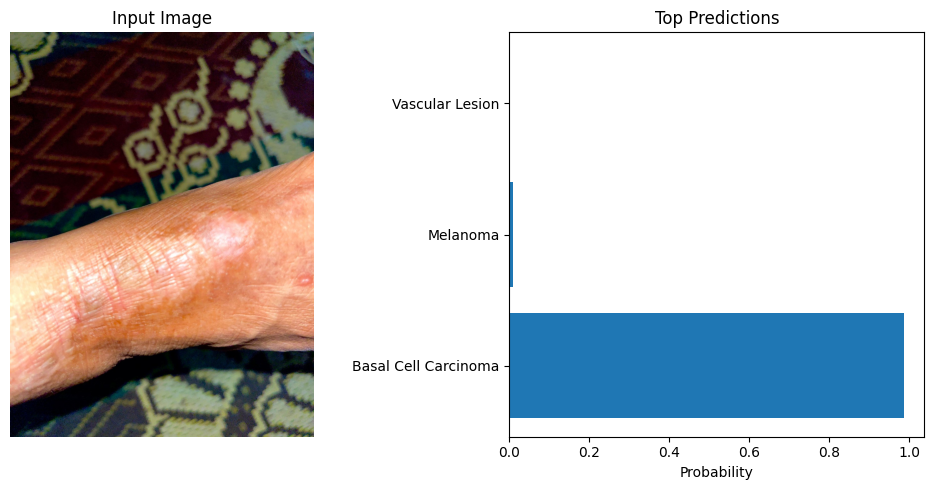


Skin Disease Detection Options:
1. Predict single image
2. Predict multiple images
3. Start webcam detection
4. Exit

Predictions:
Melanoma: 99.99%
Seborrheic Keratosis: 0.01%
Pigmented Benign Keratosis: 0.00%


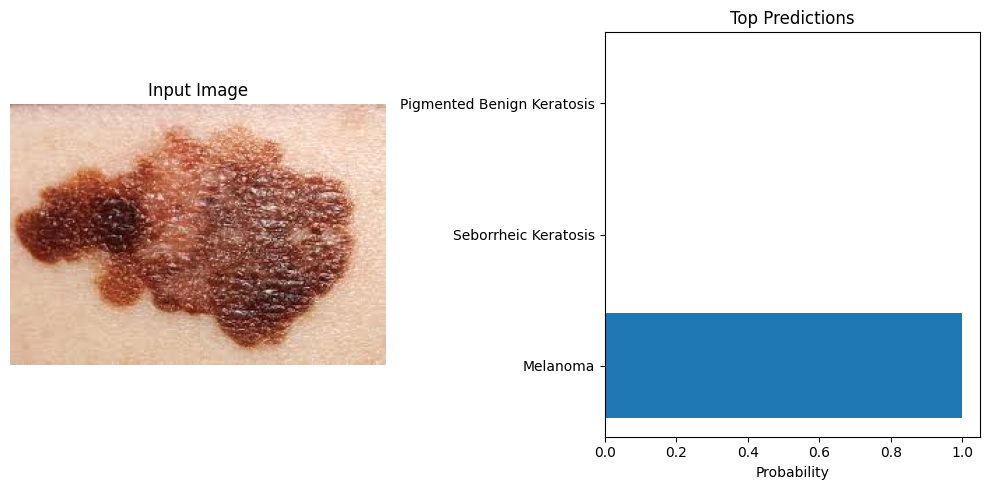


Skin Disease Detection Options:
1. Predict single image
2. Predict multiple images
3. Start webcam detection
4. Exit


In [ ]:
def main():
    # Create predictor instance
    predictor = SkinDiseasePredictor()
    
    while True:
        print("\nSkin Disease Detection Options:")
        print("1. Predict single image")
        print("2. Predict multiple images")
        print("3. Start webcam detection")
        print("4. Exit")
        
        choice = input("\nEnter your choice (1-4): ")
        
        if choice == '1':
            # Single image prediction
            image_path = input("\nEnter the path to your image: ")
            if not os.path.exists(image_path):
                print(f"Error: File not found: {image_path}")
                continue
                
            try:
                predictions = predictor.predict_single(image_path)
                
                print("\nPredictions:")
                for pred in predictions:
                    print(f"{pred['class']}: {pred['confidence']}")
                
                # Display image with predictions
                display_predictions(image_path, predictions)
                
            except Exception as e:
                print(f"Error: {str(e)}")
        
        elif choice == '2':
            # Batch prediction
            folder_path = input("\nEnter the folder path containing images: ")
            if not os.path.exists(folder_path):
                print(f"Error: Folder not found: {folder_path}")
                continue
            
            # Get all image files
            image_files = [
                os.path.join(folder_path, f) for f in os.listdir(folder_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
            ]
            
            if not image_files:
                print("No image files found in the specified folder.")
                continue
            
            print(f"\nFound {len(image_files)} images. Processing...")
            results = predictor.predict_batch(image_files)
            
            # Display results
            for result in results:
                print(f"\nImage: {result['image']}")
                if 'predictions' in result:
                    for pred in result['predictions']:
                        print(f"{pred['class']}: {pred['confidence']}")
                else:
                    print(f"Error: {result['error']}")
        
        elif choice == '3':
            # Start webcam detection
            try:
                predictor.start_webcam()
            except Exception as e:
                print(f"Error with webcam: {str(e)}")
        
        elif choice == '4':
            print("\nThank you for using the Skin Disease Detection system!")
            break
        
        else:
            print("\nInvalid choice. Please try again.")

if __name__ == "__main__":
    main()